# Clustering of spiral arms in galaxy builder subjects

### Problem:

*Given a set of polygon lines (in zooniverse coordinates), how do we recover logarithmic spirals for each physical arm present?*

First, say the jupyter magic words 🧙‍

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

Import the plethora of useful modules we'll need (including some we probably don't)

In [2]:
import json
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from gzbuilderspirals import cleaning, pipeline, get_drawn_arms
import lib.galaxy_utilities as gu

In [3]:
# font = {'family' : 'DejaVu Sans',
#         'size'   : 16}

# matplotlib.rc('font', **font)

In [4]:
subject_id = 20902040

In [5]:
c4s = gu.classifications[gu.classifications['subject_ids'] == subject_id]['annotations']
print('Received {} classifications for this subject'.format(len(c4s)))

Received 32 classifications for this subject


In [6]:
gal, angle = gu.get_galaxy_and_angle(subject_id)
pic_array, deprojected_image = gu.get_image(gal, subject_id, angle)

/Users/tlingard/PhD/galaxy-builder/data-aggregation/spiral-aggregation/lib/galaxy_utilities.py:97: UserWarning: Using montaged image
  __import__('warnings').warn('Using montaged image')
/Users/tlingard/anaconda3/lib/python3.7/site-packages/skimage/util/arraycrop.py:177: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cropped = ar[slices]


In [7]:
drawn_arms = get_drawn_arms(subject_id, gu.classifications)
print('Received {} drawn arms for this subject'.format(len(drawn_arms)))

Received 47 drawn arms for this subject


In [8]:
if os.path.exists('./lib/distances/subject-{}.npy'.format(subject_id)):
    distances = np.load('./lib/distances/subject-{}.npy'.format(subject_id))
else:
    distances = metric.calculate_distance_matrix(drawn_arms)
    np.save('./lib/distances/subject-{}.npy'.format(subject_id), distances)

In [9]:
coords, groups_all = cleaning.get_grouped_data(drawn_arms)

In [10]:
pipeline_iterator = pipeline._log_spiral_pipeline_iterator(
    drawn_arms,
    phi=angle, ba=gal['SERSIC_BA'].iloc[0],
    image_size=pic_array.shape[0],
    distances=distances,
    clean_points=False
)
labels, cleaned_points, predicted_arms = list(pipeline_iterator)

Calculate a value of pixels per arcsecond for this image

In [11]:
pix_size = pic_array.shape[0] / (gal['PETRO_THETA'].iloc[0] * 4)

Define some useful goodies for plotting later (to transform from image coordinates to arcseconds from centre of galaxy)

In [12]:
def transform_coords(c):
    return (c - pic_array.shape[0]/2)/ pix_size

imshow_kwargs = {
    'cmap': 'gray_r', 'origin': 'lower',
    'extent': (
        -pic_array.shape[0]/2 / pix_size,
        pic_array.shape[0]/2 / pix_size,
        -pic_array.shape[1]/2 / pix_size,
        pic_array.shape[1]/2 / pix_size
    ),
}
all_points = transform_coords(np.array([point for arm in cleaned_points for point in arm]))
MIN_X, MIN_Y = np.min(all_points, axis=0)
MAX_X, MAX_Y = np.max(all_points, axis=0)
def do_crop():
    mn = min(MIN_X, MIN_Y)
    mx = max(MAX_X, MAX_Y)
    plt.xlim(mn * 1.4, mx * 1.4)
    plt.ylim(mn * 1.4, mx * 1.4)

First, let's view all the drawn arms

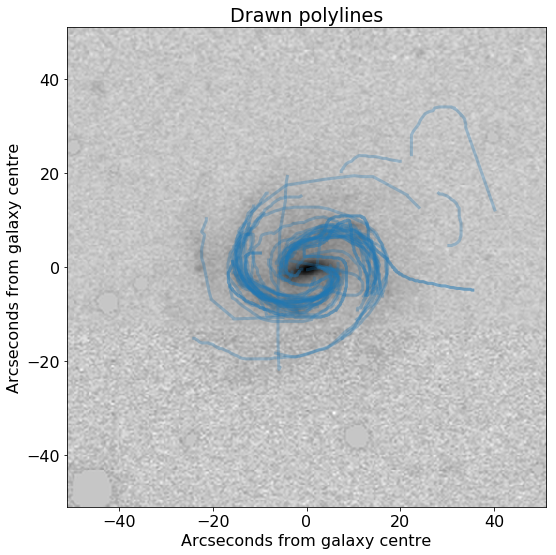

In [13]:
plt.figure(figsize=(8, 8))
plt.imshow(pic_array, **imshow_kwargs)
for arm in drawn_arms:
    plt.plot(*transform_coords(arm).T, 'C0', linewidth=3, alpha=0.3)

plt.title('Drawn polylines')
plt.xlabel('Arcseconds from galaxy centre')
plt.ylabel('Arcseconds from galaxy centre')
plt.tight_layout()
plt.savefig('method-paper-plots/drawn_polylines.pdf', bbox_inches='tight')
plt.savefig('method-paper-plots/drawn_polylines.png', bbox_inches='tight')

Now we plot the arm clusters identified

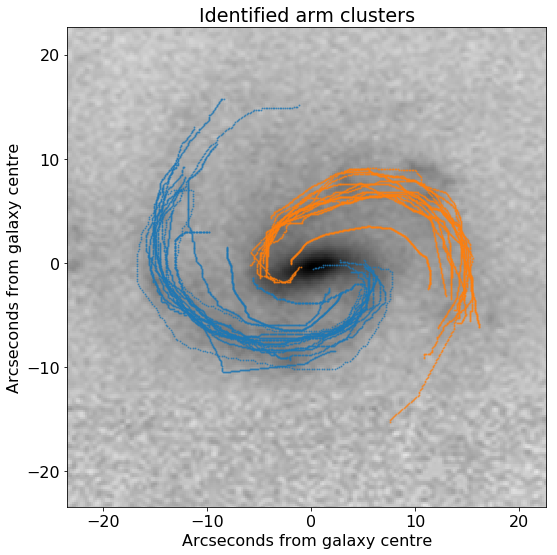

In [16]:
plt.figure(figsize=(8, 8))
plt.imshow(pic_array, **imshow_kwargs)
for point_cloud in cleaned_points:
    plt.plot(*transform_coords(point_cloud).T, '.', markersize=2, alpha=0.6)
do_crop()
plt.title('Identified arm clusters')
plt.xlabel('Arcseconds from galaxy centre')
plt.ylabel('Arcseconds from galaxy centre')
plt.tight_layout()
plt.savefig('method-paper-plots/arm_clusters.png', bbox_inches='tight')
plt.savefig('method-paper-plots/arm_clusters.pdf', bbox_inches='tight')

Finally, let's see the resulting logarithmic spirals we've fitted

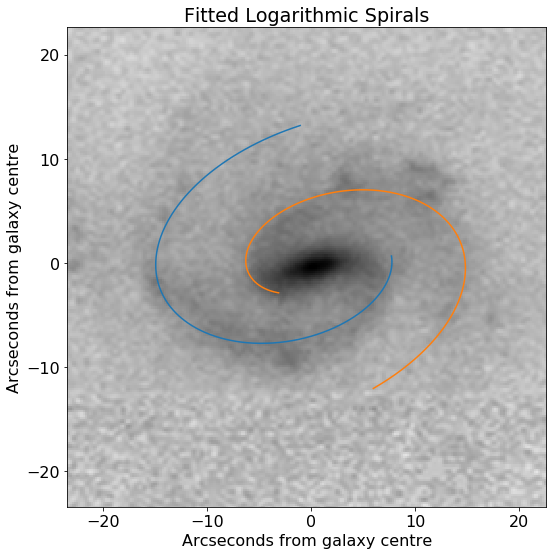

In [15]:
plt.figure(figsize=(8, 8))
plt.imshow(pic_array, **imshow_kwargs)
for arm in predicted_arms:
    plt.plot(*transform_coords(arm).T)
do_crop()
plt.title('Fitted Logarithmic Spirals')
plt.xlabel('Arcseconds from galaxy centre')
plt.ylabel('Arcseconds from galaxy centre')
plt.tight_layout()
plt.savefig('method-paper-plots/log_spirals.png', bbox_inches='tight')
plt.savefig('method-paper-plots/log_spirals.pdf', bbox_inches='tight')